In [48]:
from rdflib import Graph, URIRef, OWL
from rdflib.namespace import RDF, OWL
from rdflib.namespace import RDFS
import networkx as nx
from rdflib import Namespace
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from fuzzywuzzy import fuzz
import pandas as pd
import warnings

In [ ]:

# -------------------- Utility Functions --------------------
def name_similarity(instance1, instance2):
    """
    Measures the lexical similarity between two RDF instances using Levenshtein distance.
    Important for detecting near-identical names that may refer to the same entity.

    """
    name1 = str(instance1)
    name2 = str(instance2)
    return fuzz.ratio(name1, name2) / 100.0

def getConcepts(ontoFile):
    """
    Extracts subclass relationships from the ontology to build a class hierarchy.
    Crucial for understanding conceptual inheritance and calculating ontology-based similarity.
    """
    g = Graph()
    g.parse(ontoFile)
    children, parent = [], []
    for sub, obj in g.subject_objects(predicate=RDFS.subClassOf):
        children.append(sub.rsplit('#')[-1])
        parent.append(obj.rsplit('#')[-1])
    return parent, children

def chain_is_subchain(sub, full):
    """
    Checks if one chain of concepts is fully embedded in another.
    Useful for avoiding redundant taxonomic chains during hierarchy construction.
    """

    if len(sub) > len(full):
        sub, full = full, sub
    for i in range(len(full) - len(sub) + 1):
        if full[i:i + len(sub)] == sub:
            return True
    return False

def createChains(parent, children):
    """
    Constructs all concept chains (lineages) from the ontology's subclass relationships.
    Important for identifying conceptual depth and common ancestors.
    """
    chains = []
    for i in range(len(children)):
        chain = [children[i], parent[i]]
        j = i
        while parent[j] in children:
            j = children.index(parent[j])
            chain.append(parent[j])
        for existing in chains:
            if chain_is_subchain(chain, existing):
                break
        else:
            chains.append(chain)
    return chains

def consim(filettl, concept1, concept2):
    """
    Calculates conceptual similarity between two concepts based on shared hierarchy.
    Important for semantic reasoning and detecting ontological closeness.
    """
    parent, children = getConcepts(filettl)
    chains = createChains(parent, children)
    chain1 = next((c[c.index(concept1):] for c in chains if concept1 in c), [])
    chain2 = next((c[c.index(concept2):] for c in chains if concept2 in c), [])
    intersect = set(chain1).intersection(chain2)
    if not chain1 or not chain2:
        return 0
    nr2 = len(intersect) * 2
    total = len(chain1) + len(chain2)
    similarity = nr2 / (total - len(intersect)) if (total - len(intersect)) != 0 else 0
    return min(similarity, 1.0)

In [ ]:
# -------------------- Main Similarity Analyzer --------------------
def analyze_similarity(Graph3, Graph4, g, onto_file, ressource1, ressource2, bonneRelation):

    """
    Core function that compares two RDF nodes by:
    - Analyzing their linked entities
    - Calculating conceptual, embedding, and lexical similarities
    - Suggesting equivalences (owl:sameAs) when appropriate
    Crucial for automated alignment and fusion of semantic data.
    """
        
    vectors = Node2Vec(Graph4, dimensions=32, walk_length=30, num_walks=200, workers=4, p=1.0, q=0.1).fit(window=10, min_count=1).wv
    df = pd.DataFrame(columns=['Entité A', 'Entité B', 'Similarité conceptuel', 'Similarité de plongement', 'Similarité Finale', 'Similarité de surface'])
    ns = Namespace("http://www.semanticweb.org/serge/ontologies/2022/10/pko-onto#")

    edges1 = [(s, t, r['relation']) for s, t, r in Graph4.edges(data=True) if s == ressource1 and r.get("relation") == bonneRelation]
    edges2 = [(s, t, r['relation']) for s, t, r in Graph4.edges(data=True) if s == ressource2 and r.get("relation") == bonneRelation]

    for e1 in edges1:
        for e2 in edges2:
            node1, node2 = e1[1], e2[1]
            concept1 = next((src for src, dst in Graph3.edges if dst == node1), None)
            concept2 = next((src for src, dst in Graph3.edges if dst == node2), None)
            if not concept1 or not concept2:
                continue

            sim_embed = vectors.similarity(node1, node2)
            sim_concept = consim(onto_file, concept1, concept2)
            sim_final = 0.75 * sim_concept + 0.25 * sim_embed

            uri1 = URIRef(f"{ns}{node1}")
            uri2 = URIRef(f"{ns}{node2}")
            surface1 = g.value(uri1, ns.resourceName, None) or node1
            surface2 = g.value(uri2, ns.resourceName, None) or node2
            sim_surface = name_similarity(surface1, surface2)

            # Always print the similarities
            print(f"Similarity Concept between Node {concept1} and Node {concept2}: {sim_concept}")
            print(f"Similarity Embedding between Node {node1} and Node {node2}: {sim_embed}")
            print(f"Similarity Final between Node {node1} and Node {node2}: {sim_final}")

            new_row = pd.Series([node1, node2, sim_concept, sim_embed, sim_final, sim_surface], index=df.columns)
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

            if 0.5 <= sim_final < 1.0 and 0.5 <= sim_surface < 1.0:
                print(f"\033[1;34mSurface Similarity between {node1} and {node2}: {sim_surface}\033[0m")
                print("\033[91m\033[1mFusion réussie avec succès !\033[0m")
                g.add((uri1, OWL.sameAs, uri2))

    g.serialize("result.ttl", format="turtle")
    return df, vectors


In [ ]:
# -------------------- Visualization --------------------
def visualize_embeddings(vectors):

    """
    Reduces high-dimensional node embeddings to 2D using t-SNE and visualizes them.
    Important for exploring the distribution and clustering of RDF nodes in embedding space.
    """
        
    labels = list(vectors.key_to_index.keys())
    embeddings = np.array([vectors[label] for label in labels])  # Ensure it's a numpy array

    if len(embeddings) < 2:
        print("Not enough nodes to visualize with t-SNE.")
        return

    perplexity = min(30, max(2, len(embeddings) // 3))  # Adjust for small datasets

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.annotate(label, (x, y), fontsize=8)
    plt.title("t-SNE visualization of Node2Vec embeddings")
    plt.show()

In [ ]:
def visualize_graph(Graph4):
    """
    Visualizes the RDF graph using NetworkX with labeled relations.
    Helpful for understanding the structure and semantics of RDF data visually.
    """
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(Graph4, seed=42, k=0.5)
    edge_labels = nx.get_edge_attributes(Graph4, 'relation')

    nx.draw(Graph4, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=8, font_weight='bold', edge_color='gray')
    nx.draw_networkx_edge_labels(Graph4, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Graph RDF avec relations étiquetées", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# -------------------- Graph Construction from RDF --------------------
def build_graphs_from_rdf(g):

    """
    Parses the RDF ontology and constructs several graphs:
    - Graph1: instance graph
    - Graph2: class-instance relationships
    - Graph3: concept-instance linkage (for reasoning)
    - Graph4: full semantic graph (for embeddings)
    Essential for structuring RDF data for analysis and machine learning.
    """
    E, V, R, O = [], [], [], []
    Graph1 = nx.Graph()
    Graph2 = nx.Graph()
    Graph3 = nx.Graph()
    Graph4 = nx.Graph()

    i = j = CompteClass = 1

    for className in g.subjects(RDF.type, OWL.Class):
        class_label = className.split("#")[-1]
        E.append(class_label)
        Graph2.add_node(i, name=class_label)
        Graph3.add_node(CompteClass, name=class_label)
        CompteClass += 1

        for instance in g.subjects(RDF.type, className):
            instance_label = instance.split("#")[-1]
            V.append(instance_label)
            Graph1.add_node(j, name=instance_label)
            Graph2.add_edge(i, j, relation="Type")
            Graph3.add_edge(class_label, instance_label, relation="Type")
            Graph4.add_node(instance_label)
            Graph4.add_edge(class_label, instance_label, relation="type")

            for relation, obj in g.predicate_objects(instance):
                if obj.split("#")[-1] in V:
                    R.append(relation.split("#")[-1])
                    O.append(obj.split("#")[-1])
                    Graph4.add_edge(instance_label, obj.split("#")[-1], relation=relation.split("#")[-1])
        i += 1

    return Graph1, Graph2, Graph3, Graph4, E, V, R, O

In [44]:
# -------------------- Entry Point --------------------
if __name__ == "__main__":
    onto_file = "pkmoontologySchool2.ttl"
    ressource1 = input("Entrez le nom du nœud 1 : ")
    ressource2 = input("Entrez le nom du nœud 2 : ")
    bonneRelation = input("Entrez le nom de la relation : ")

    g = Graph()
    g.parse(onto_file)

    Graph1, Graph2, Graph3, Graph4, E, V, R, O = build_graphs_from_rdf(g)

    # Reconstruct Graph3 and Graph4 from ontology
    Graph3 = nx.Graph()
    Graph4 = nx.Graph()

    for s, p, o in g:
        if p == RDF.type and o != OWL.Class:
            Graph3.add_edge(s.rsplit("#")[-1], o.rsplit("#")[-1], relation="Type")
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            Graph4.add_edge(s.rsplit("#")[-1], o.rsplit("#")[-1], relation=p.rsplit("#")[-1] if "#" in str(p) else str(p))

    df_result, vectors = analyze_similarity(Graph3, Graph4, g, onto_file, ressource1, ressource2, bonneRelation)
    print(df_result)


Computing transition probabilities:   0%|          | 0/153 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 98.68it/s] 


Similarity Concept between Node DocResource and Node HardResource: 0.8
Similarity Embedding between Node PythonBook01 and Node LCDProjector02: 0.5523771643638611
Similarity Final between Node PythonBook01 and Node LCDProjector02: 0.7380942910909654
Similarity Concept between Node DocResource and Node DocResource: 1.0
Similarity Embedding between Node PythonBook01 and Node ComputerIntroduction: 0.9296485185623169
Similarity Final between Node PythonBook01 and Node ComputerIntroduction: 0.9824121296405792
Similarity Concept between Node DocResource and Node VideoResource: 1.0
Similarity Embedding between Node PythonBook01 and Node VideoPython02: 0.5755165219306946
Similarity Final between Node PythonBook01 and Node VideoPython02: 0.8938791304826736
Surface Similarity between PythonBook01 and VideoPython02: 0.78
Fusion réussie avec succès !
Similarity Concept between Node DocResource and Node HardResource: 0.8
Similarity Embedding between Node PythonBook01 and Node Laptop03: 0.55317413806

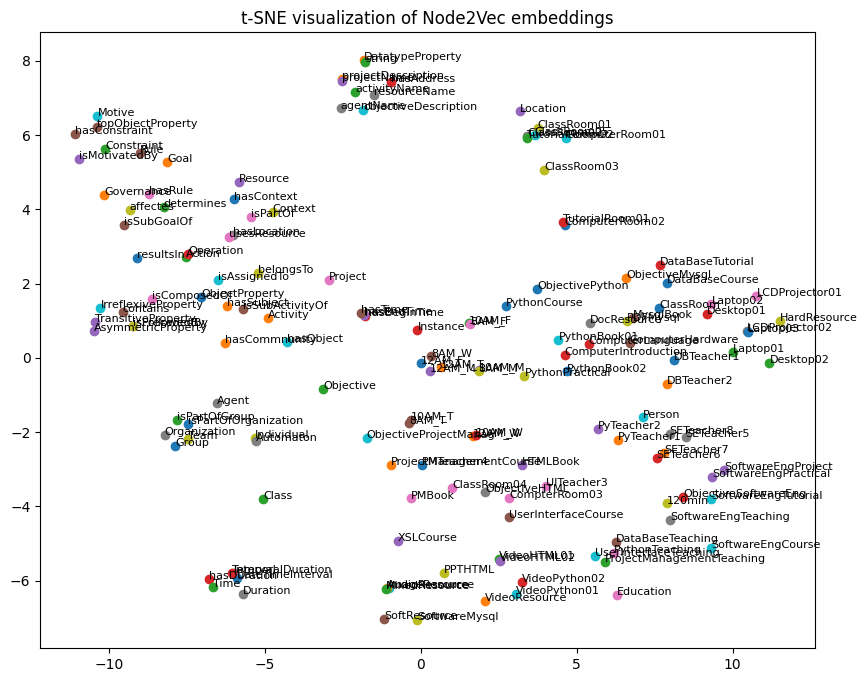

In [45]:
# Optional: visualize the embeddings
visualize_embeddings(vectors)

In [46]:
 # ----------- MRR Calculation and Sorting -----------
df_sorted = df_result.sort_values(by='Similarité conceptuel', ascending=False).reset_index(drop=True)
print("🔍 DataFrame trié par similarité conceptuelle:")
print(df_sorted)

df_filtered = df_sorted[(df_sorted['Similarité de surface'] > 0.5) & (df_sorted['Similarité de surface'] < 1)]
index_filtres = df_filtered.index

print(" Index des lignes filtrées:")
for idx in index_filtres:
    print(f"Index de la ligne filtrée : {idx}")

nombre_d_index = len(index_filtres)
print(f" Nombre d'éléments filtrés : {nombre_d_index}")

mrr_sum = sum(1.0 / (idx + 1) for idx in index_filtres)
mrr_global = mrr_sum / nombre_d_index if nombre_d_index > 0 else 0.0

print(f" MRR global : {mrr_global:.4f}")

🔍 DataFrame trié par similarité conceptuelle:
                Entité A              Entité B  Similarité conceptuel  \
0           PythonBook01  ComputerIntroduction                    1.0   
1           PythonBook01         VideoPython02                    1.0   
2   ComputerIntroduction  ComputerIntroduction                    1.0   
3           PythonBook01          PythonBook02                    1.0   
4          VideoPython01  ComputerIntroduction                    1.0   
5          VideoPython01         VideoPython02                    1.0   
6   ComputerIntroduction         VideoPython02                    1.0   
7   ComputerIntroduction          PythonBook02                    1.0   
8               Laptop01        LCDProjector02                    1.0   
9               Laptop01              Laptop03                    1.0   
10         VideoPython01          PythonBook02                    1.0   
11          PythonBook01        LCDProjector02                    0.8   
12   

/tmp/ipykernel_1675938/41791134.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


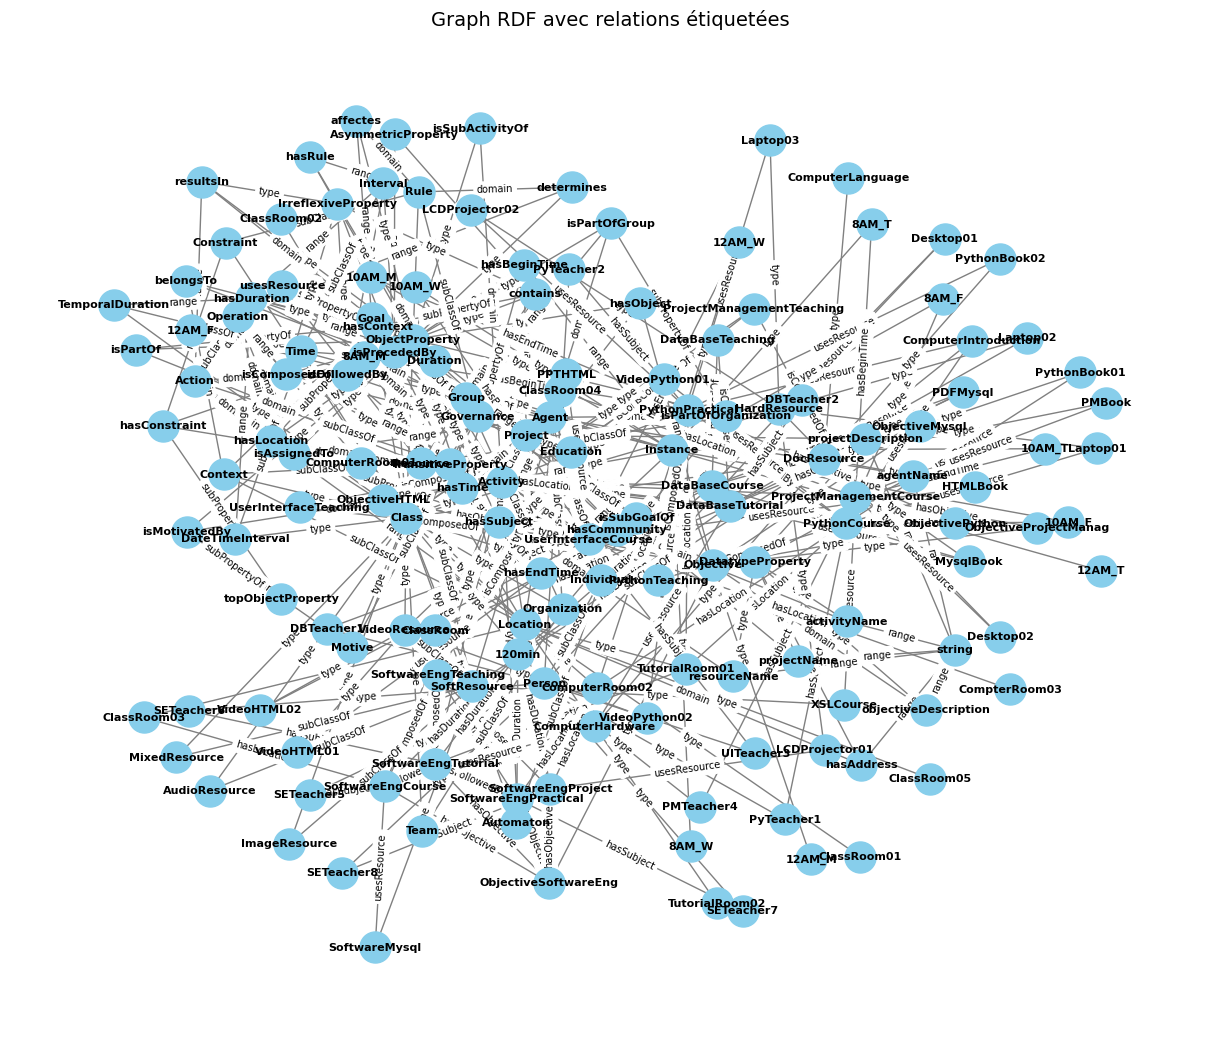

In [47]:
visualize_graph(Graph4)